
# Audio I/O

**Modified notebook from the original one made by**: [Moto Hira](https://pytorch.org/audio/stable/tutorials/audio_io_tutorial.html)

This tutorial shows how to use TorchAudio's basic I/O API to load audio files
into PyTorch's Tensor object, and save Tensor objects to audio files.


In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.3.0.dev20240222
2.2.0.dev20240222


## Preparation

First, we import the modules and download the audio assets we use in this tutorial.

<div class="alert alert-info"><h4>Note</h4><p>When running this tutorial in Google Colab, install the required packages
   with the following:
   .. code::

      !pip install boto3</p></div>



In [2]:
import io
import os
import tarfile
import tempfile

# import boto3
import matplotlib.pyplot as plt
import requests
# from botocore import UNSIGNED
# from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

SAMPLE_WAV = "../audio/raw/bss-td3.wav"

## Querying audio metadata

Function :py:func:`torchaudio.info` fetches audio metadata.
You can provide a path-like object or file-like object.




In [3]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

AudioMetaData(sample_rate=48000, num_frames=192000, num_channels=1, bits_per_sample=24, encoding=PCM_S)


Where

-  ``sample_rate`` is the sampling rate of the audio
-  ``num_channels`` is the number of channels
-  ``num_frames`` is the number of frames per channel
-  ``bits_per_sample`` is bit depth
-  ``encoding`` is the sample coding format

``encoding`` can take on one of the following values:

-  ``"PCM_S"``: Signed integer linear PCM
-  ``"PCM_U"``: Unsigned integer linear PCM
-  ``"PCM_F"``: Floating point linear PCM
-  ``"FLAC"``: Flac, [Free Lossless Audio
   Codec](https://xiph.org/flac/)_
-  ``"ULAW"``: Mu-law,
   [[wikipedia](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm)_]
-  ``"ALAW"``: A-law
   [[wikipedia](https://en.wikipedia.org/wiki/A-law_algorithm)_]
-  ``"MP3"`` : MP3, MPEG-1 Audio Layer III
-  ``"VORBIS"``: OGG Vorbis [[xiph.org](https://xiph.org/vorbis/)_]
-  ``"AMR_NB"``: Adaptive Multi-Rate
   [[wikipedia](https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_audio_codec)_]
-  ``"AMR_WB"``: Adaptive Multi-Rate Wideband
   [[wikipedia](https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_Wideband)_]
-  ``"OPUS"``: Opus [[opus-codec.org](https://opus-codec.org/)_]
-  ``"GSM"``: GSM-FR
   [[wikipedia](https://en.wikipedia.org/wiki/Full_Rate)_]
-  ``"HTK"``: Single channel 16-bit PCM
-  ``"UNKNOWN"`` None of above




**Note**

-  ``bits_per_sample`` can be ``0`` for formats with compression and/or
   variable bit rate (such as MP3).
-  ``num_frames`` can be ``0`` for GSM-FR format.




## Loading audio data

To load audio data, you can use :py:func:`torchaudio.load`.

This function accepts a path-like object or file-like object as input.

The returned value is a tuple of waveform (``Tensor``) and sample rate
(``int``).

By default, the resulting tensor object has ``dtype=torch.float32`` and
its value range is ``[-1.0, 1.0]``.

For the list of supported format, please refer to [the torchaudio
documentation](https://pytorch.org/audio)_.




In [4]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [5]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

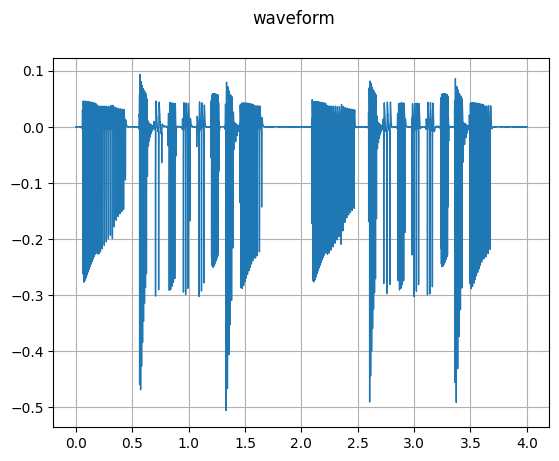

In [6]:
plot_waveform(waveform, sample_rate)

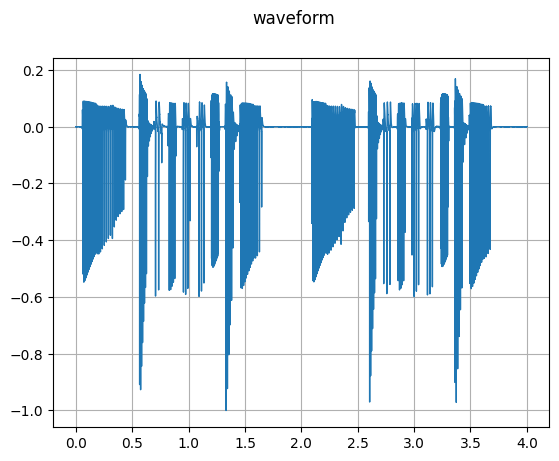

In [7]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)
waveform /= torch.max(torch.abs(waveform))
plot_waveform(waveform, sample_rate)

In [8]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

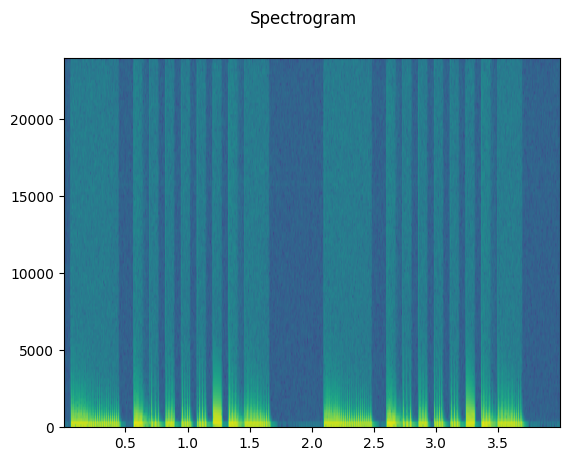

In [9]:
plot_specgram(waveform, sample_rate)

In [10]:
Audio(waveform.numpy()[0], rate=sample_rate)

## Saving audio to file

To save audio data in formats interpretable by common applications,
you can use :py:func:`torchaudio.save`.

This function accepts a path-like object or file-like object.

When passing a file-like object, you also need to provide argument ``format``
so that the function knows which format it should use. In the
case of a path-like object, the function will infer the format from
the extension. If you are saving to a file without an extension, you need
to provide argument ``format``.

When saving WAV-formatted data, the default encoding for ``float32`` Tensor
is 32-bit floating-point PCM. You can provide arguments ``encoding`` and
``bits_per_sample`` to change this behavior. For example, to save data
in 16-bit signed integer PCM, you can do the following.

<div class="alert alert-info"><h4>Note</h4><p>Saving data in encodings with a lower bit depth reduces the
   resulting file size but also precision.</p></div>




In [11]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

In [12]:
def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")
    print()

Save without any encoding option.
The function will pick up the encoding which
the provided data fit



In [13]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_default.wav"
    torchaudio.save(path, waveform, sample_rate)
    inspect_file(path)

----------
Source: /var/folders/yq/mvb7f1jd0y7dbw4v5k8x2s_r0000gn/T/tmp_il4_nty/save_example_default.wav
----------
 - File size: 768058 bytes
 - AudioMetaData(sample_rate=48000, num_frames=192000, num_channels=1, bits_per_sample=32, encoding=PCM_F)



Save as 16-bit signed integer Linear PCM
The resulting file occupies half the storage but loses precision



In [14]:
with tempfile.TemporaryDirectory() as tempdir:
    path = f"{tempdir}/save_example_PCM_S16.wav"
    torchaudio.save(path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16)
    inspect_file(path)

----------
Source: /var/folders/yq/mvb7f1jd0y7dbw4v5k8x2s_r0000gn/T/tmptwhaks77/save_example_PCM_S16.wav
----------
 - File size: 384044 bytes
 - AudioMetaData(sample_rate=48000, num_frames=192000, num_channels=1, bits_per_sample=16, encoding=PCM_S)



:py:func:`torchaudio.save` can also handle other formats.
To name a few:




In [15]:
formats = [
    "flac",
    "vorbis",
    "sph",
    "amb",
    "amr-nb",
    "gsm",
]

## Saving to file-like object

Similar to the other I/O functions, you can save audio to file-like
objects. When saving to a file-like object, argument ``format`` is
required.




In [16]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

# Saving to bytes buffer
buffer_ = io.BytesIO()
torchaudio.save(buffer_, waveform, sample_rate, format="wav")

buffer_.seek(0)
print(buffer_.read(16))

b'RIFFH\xb8\x0b\x00WAVEfmt '
